# Anomaly Detection - JnJ Dataset

Inspiration from https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9

In [1]:
from utils.data.jnj import data_reader 
from utils.data.jnj import data_plot 
from utils.data import data_util
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [2]:
reader = data_reader.ReadData()
dataset = reader.load_data()

Reading:  /lhome/ruocco/anomaly-detection-gnn/anomaly_detection/utils/data/jnj/dataset/JNJ.csv
....Dropped Missing value row....
Rechecking Missing values: Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(8823, 6)


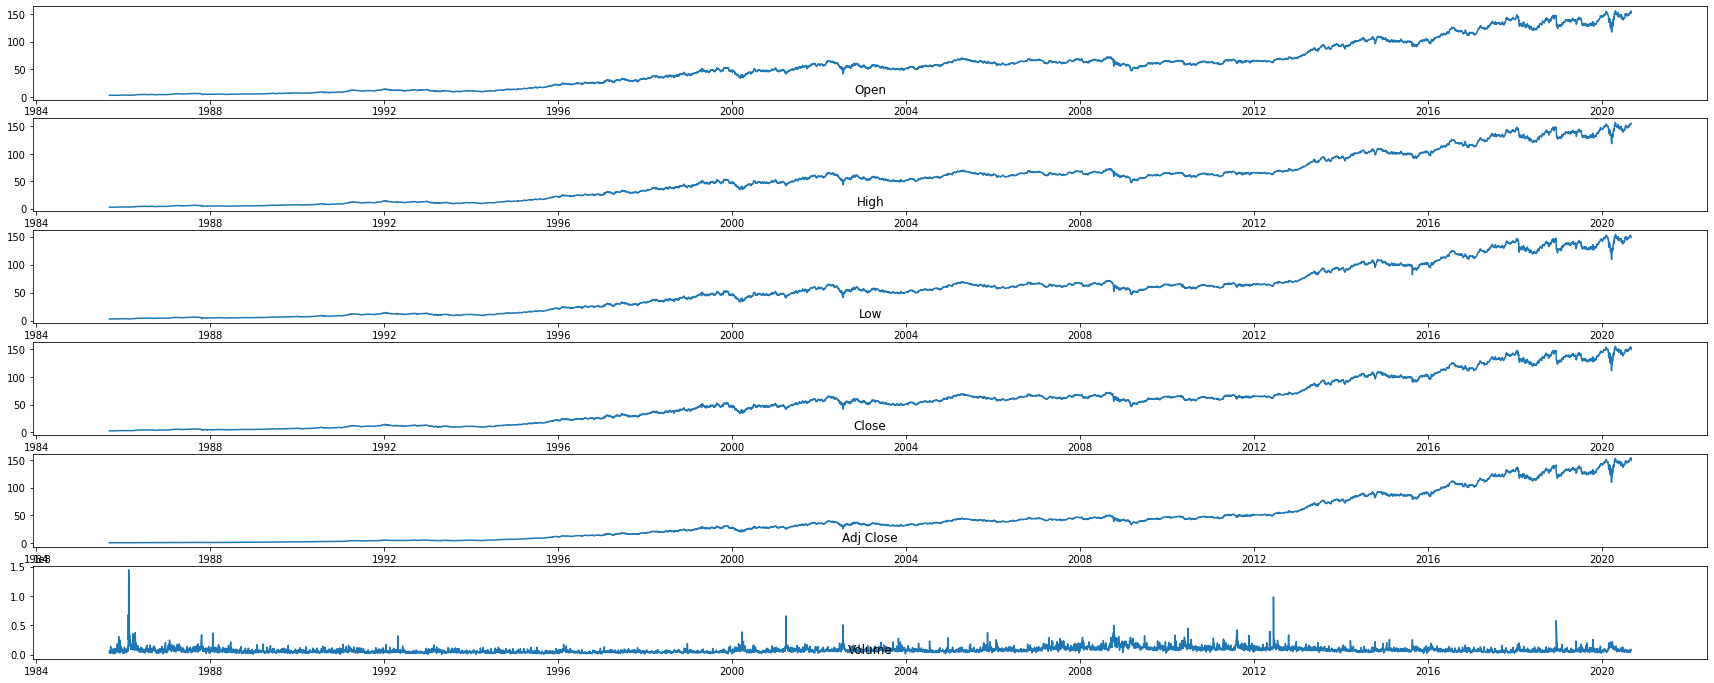

In [3]:
data_plot.plot(dataset)

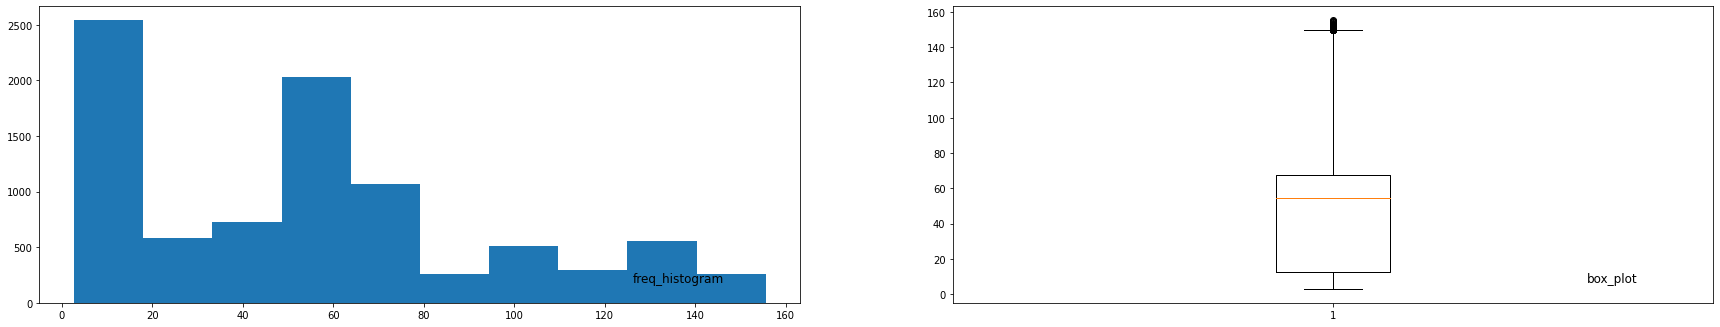

In [4]:
data_util.vis_behaviour(dataset, dataset.columns[0])

In [5]:
dataset = dataset[["Close"]]
dataset.head()

,Close
datetime,
1985-09-04,2.953125
1985-09-05,2.976563
1985-09-06,2.992188
1985-09-09,2.945313
1985-09-10,2.875000


In [6]:
dataset.index.min(), dataset.index.max()

(Timestamp('1985-09-04 00:00:00'), Timestamp('2020-09-03 00:00:00'))

In [8]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
train, test = data_util.split(dataset, dataset.columns[0], scaler=scaler, test_size=0.2)

Train_shape:  (7058, 1)
Test_shape:  (1765, 1)
Data Standardization with  StandardScaler()


In [9]:
print(train.shape,test.shape)

(7058, 1) (1765, 1)


In [10]:
col_name = dataset.columns[0]
n_steps = 32
X_train, y_train = data_util.create_dataset(train[[col_name]], train[col_name], n_steps)
X_test, y_test = data_util.create_dataset(test[[col_name]], test[col_name], n_steps)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print("-------------------")

X_train shape: (7026, 32, 1)
X_test shape: (1733, 32, 1)
y_train shape: (7026,)
y_test shape: (1733,)
-------------------


In [11]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
units = 128
dropout = 0.2
loss = 'mae'
optimizer = 'adam'

from tensorflow import keras
from models import keras_lstm_ae
model = keras_lstm_ae.create_lstm_ae(input_shape=(n_timesteps, n_features), dropout=dropout, units=units)
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.compile(loss = loss, optimizer = optimizer)
model.summary()

Model: "lstm_ae_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 32, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 32, 1)           

In [12]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False) #X_train

Epoch 1/100
198/198 [==============================] - 10s 41ms/step - loss: 0.2280 - val_loss: 0.1981
Epoch 2/100
198/198 [==============================] - 7s 37ms/step - loss: 0.1856 - val_loss: 0.1336
Epoch 3/100
198/198 [==============================] - 7s 37ms/step - loss: 0.1038 - val_loss: 0.0406
Epoch 4/100
198/198 [==============================] - 7s 37ms/step - loss: 0.0879 - val_loss: 0.0307
Epoch 5/100
198/198 [==============================] - 7s 37ms/step - loss: 0.0963 - val_loss: 0.0266
Epoch 6/100
198/198 [==============================] - 7s 37ms/step - loss: 0.1123 - val_loss: 0.0286
Epoch 7/100
198/198 [==============================] - 7s 37ms/step - loss: 0.1246 - val_loss: 0.0402
Epoch 8/100
198/198 [==============================] - 7s 37ms/step - loss: 0.1400 - val_loss: 0.0329


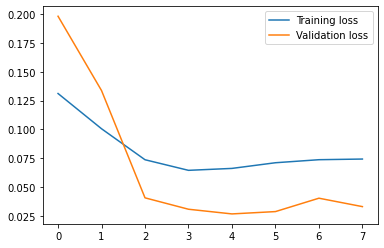

In [13]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='Training loss')
pyplot.plot(history.history['val_loss'], label='Validation loss')
pyplot.legend();

In [14]:
model.evaluate(X_test, y_test)


55/55 [==============================] - 1s 9ms/step - loss: 0.2658


0.26576554775238037

Reconstruction error threshold: 0.6469421535979865


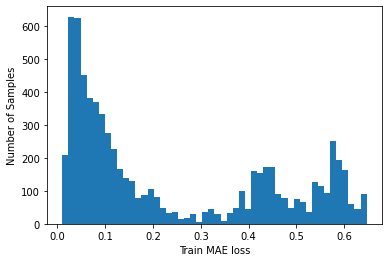

In [15]:
import numpy as np
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

pyplot.hist(train_mae_loss, bins=50)
pyplot.xlabel('Train MAE loss')
pyplot.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

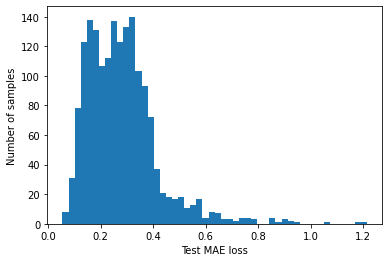

In [16]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

pyplot.hist(test_mae_loss, bins=50)
pyplot.xlabel('Test MAE loss')
pyplot.ylabel('Number of samples');

In [17]:
test_score_df = pd.DataFrame(test[n_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold*1
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[n_steps:]['Close']


In [18]:
test_score_df.tail()


,Close,loss,threshold,anomaly
datetime,,,,
2020-08-28,4.691997,0.306203,0.646942,False
2020-08-31,4.682694,0.299612,0.646942,False
2020-09-01,4.606246,0.303506,0.646942,False
2020-09-02,4.699682,0.334956,0.646942,False
2020-09-03,4.526563,0.329526,0.646942,False


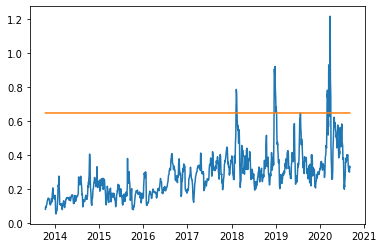

In [19]:
pyplot.plot(test_score_df['loss'])
pyplot.plot(test_score_df['threshold'])


In [20]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.head()

,Close,loss,threshold,anomaly
datetime,,,,
2018-02-07,3.793235,0.693265,0.646942,True
2018-02-08,3.588567,0.704440,0.646942,True
2018-02-09,3.716788,0.785204,0.646942,True
2018-02-12,3.746720,0.760340,0.646942,True
2018-02-13,3.734181,0.704199,0.646942,True


In [21]:
test_score_df

,Close,loss,threshold,anomaly
datetime,,,,
2013-10-17,2.197549,0.081859,0.646942,False
2013-10-18,2.183796,0.095375,0.646942,False
2013-10-21,2.166403,0.097483,0.646942,False
2013-10-22,2.213323,0.091924,0.646942,False
2013-10-23,2.202807,0.097955,0.646942,False
...,...,...,...,...
2020-08-28,4.691997,0.306203,0.646942,False
2020-08-31,4.682694,0.299612,0.646942,False
2020-09-01,4.606246,0.303506,0.646942,False


In [22]:
anomalies

,Close,loss,threshold,anomaly
datetime,,,,
2018-02-07,3.793235,0.693265,0.646942,True
2018-02-08,3.588567,0.704440,0.646942,True
2018-02-09,3.716788,0.785204,0.646942,True
2018-02-12,3.746720,0.760340,0.646942,True
2018-02-13,3.734181,0.704199,0.646942,True
2018-02-14,3.722450,0.668456,0.646942,True
2018-02-15,3.785550,0.651443,0.646942,True
2018-12-18,3.752787,0.760616,0.646942,True
2018-12-19,3.639127,0.843807,0.646942,True


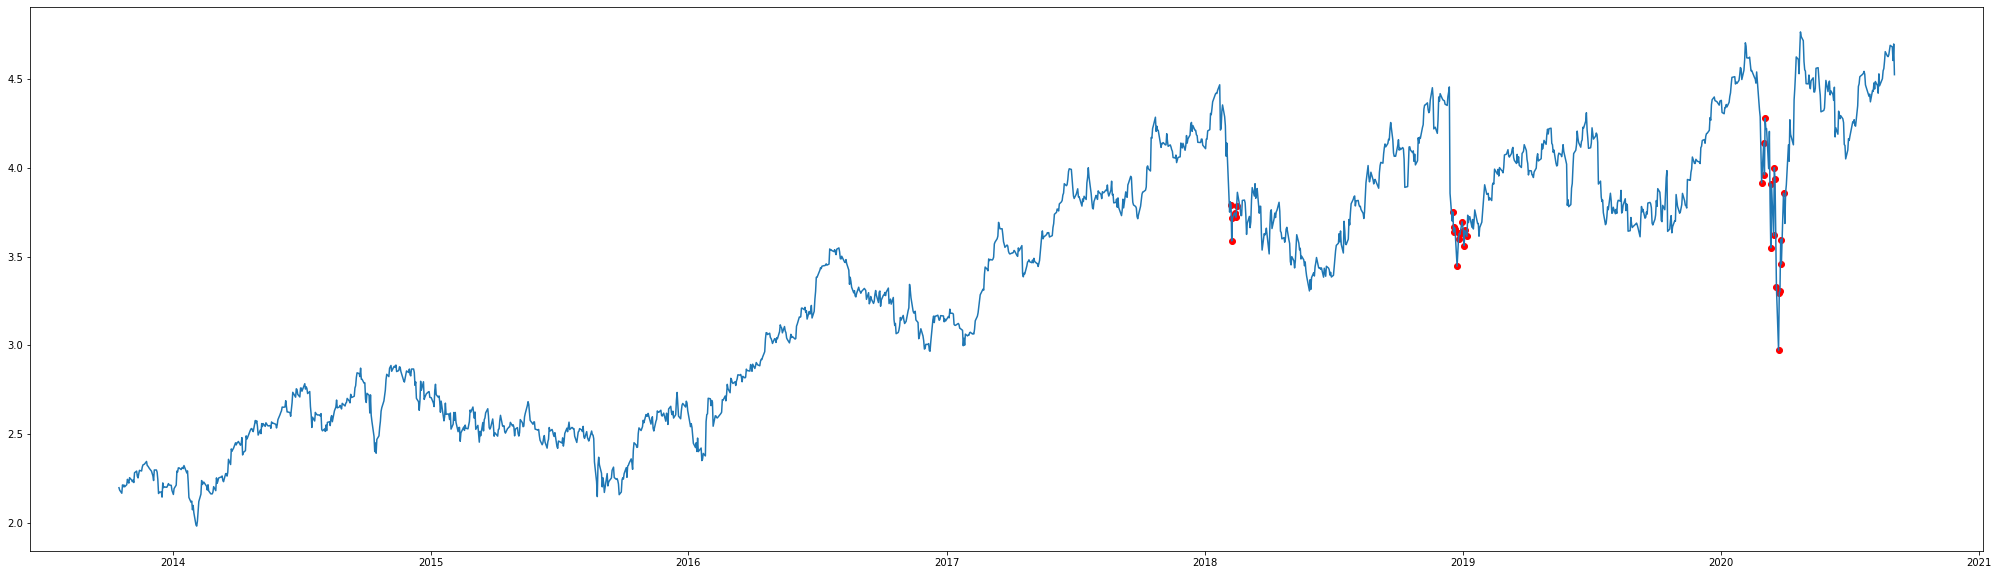

In [23]:
pyplot.figure(figsize=(35,10))
pyplot.plot(test_score_df.index, (test_score_df['Close']))
pyplot.scatter(anomalies.index, (anomalies['Close']), marker='o', color="red")